# Portfolio Performance Analysis

This code compares the returns of my portfolio to the S&P 500 (only code ready for GitHub)

## Preparing Data

**Import Packages**

In [45]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import unicodedata
import datetime
import sys
from pandas.tseries.offsets import BMonthEnd
from datetime import date
import bs4 as bs
#import pandas_datareader.data as web

**Inputs**:
1. Start date for performance analysis
2. End date for performance analysis
3. File name of trading all portfolio trading activity

In [46]:
#when to start analysis and the file of trading activity
start_date_string = '2018-01-31'
end_date_string = '2018-07-31'
file_name = 'All Activity 01_01_2018 to 07_31_2018.csv'

#converting dates to the proper format
start_date = pd.to_datetime(start_date_string)
end_date = pd.to_datetime(end_date_string)

**Data Wrangling:** Code to read in the trading activity, remove rows and columns we don't need, and convert all dates to month-end dates (we'll be finding monthly returns). 

In [47]:
#read in the raw DataFrame
raw_df = pd.read_csv(file_name)
#Chop off the empty rows at the top
df=raw_df.iloc[5:]
#Create new columns names
new_columns = raw_df.iloc[4][0:14].tolist()
#Set the new column names as the columns of the DataFrame
df.columns = new_columns
#remove the Check and Card number columns
df=df.drop(['Check Number','Card Number'],axis=1)
#remove the last two columns that just contain nans
df=df[df.columns[:-2]]

#set the names of the numeric columns
numeric_cols =['Quantity','Price($)','Amount($)','Running Balance']
#remove all of the commas in the numbers in the DataFrame
df[numeric_cols] = df[numeric_cols].replace({',':''}, regex=True)
#change df to numeric
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

#find the last row of data in the DataFrame
last_row = df['Quantity'].index[df['Quantity'].apply(np.isnan)][0]
#make the DataFrame include everything until the last row (adjustment made for index starting at 5)
df = df[0:last_row-df.index[0]]

#defining a helpful function
def convert_to_BM(date):
    #function to convert a given date into the end of that month's business date
    offset = BMonthEnd()
    new_date = offset.rollforward(date)
    return new_date

#convert the Transaction Date to a datetime format
df['Transaction Date']=pd.to_datetime(df['Transaction Date'])
#convert the Activity Date to a datetime format
df['Activity Date']=pd.to_datetime(df['Activity Date'])
#build a new DataFrame column that contains the month for the activity
df['Adj Transaction Date']=df.apply(lambda x: convert_to_BM(x['Transaction Date']), axis=1)

#find all of the unique end of month dates in the data
month_dates = df['Adj Transaction Date'].unique()

**More Data Wrangling:** Code to read in historical portfolio value history and determine (based on the inputs) when we should start and end our analysis.

In [48]:
#for internal rate of return, we just care about the starting value of our securities, the cash flows into annd
#out of our portfolio, and the ending value of our portfolio. For this reason, we will subtract out how much cash
#we have in our portfolio in the beginning and the end.
#starting_value = 60268.71 * -1
#ending_value = 64570.93

#read in csv containing data on portfolio value
history_df=pd.read_csv('Value of Portfolio History.csv')
#remove unnecessary columns
history_df = history_df[history_df.columns[:6]]

#set the names of the numeric columns
numeric_cols_2 = history_df.columns[1:6]
#change df to numeric
history_df[numeric_cols_2] = history_df[numeric_cols_2].apply(pd.to_numeric, errors='coerce')

#find the last row of data in the DataFrame
#last_row_2 = history_df['Total Value of Portfolio'].index[history_df['Total Value of Portfolio'].apply(np.isnan)][0]
#make the DataFrame include everything until the last row (adjustment made for index starting at 5)
#history_df = history_df[0:last_row_2-history_df.index[0]]
#convert date column into datetime format
history_df['Date']=pd.to_datetime(history_df['Date'])

#finding the start_index and end_index (for later use)
#if the date we want to start at is before any available data...
if start_date < history_df['Date'][0]: 
    #start the cash flows at the very beginning of the data
    start_index = 0
else:
    #start index at the point of the first date
    start_index = history_df[history_df['Date']==start_date].index[0] 

#Find index of last date we have
end_index = history_df[history_df['Date']==end_date].index[0] 



## Portfolio vs. Benchmark

Next section: pull the monthly return of the S&P 500 by month, and compare my portfolio with the S&P 500.

**Defining a Class**: As of July 2018, the traditional pandas datareader method for pulling data from Yahoo is deprecated. Here is some code I found from GitHub that pulls it for me:

In [49]:
class YahooDailyReader():
#https://gist.github.com/stoffprof/719ae8d876d3a5539112e74d292339c9
    def __init__(self, symbol=None, start=None, end=None):
        import datetime, time
        self.symbol = symbol
        
        # initialize start/end dates if not provided
        if end is None:
            end = datetime.datetime.today()
        if start is None:
            start = datetime.datetime(2010,1,1)
        
        self.start = start
        self.end = end
        
        # convert dates to unix time strings
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))
        
        url = 'https://finance.yahoo.com/quote/{}/history?'
        url += 'period1={}&period2={}'
        url += '&filter=history'
        url += '&interval=1d'
        url += '&frequency=1d'
        self.url = url.format(self.symbol, unix_start, unix_end)
        
    def read(self):
        import requests, re, json
       
        r = requests.get(self.url)
        
        ptrn = r'root\.App\.main = (.*?);\n}\(this\)\);'
        txt = re.search(ptrn, r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        df = pd.DataFrame(
                jsn['context']['dispatcher']['stores']
                ['HistoricalPriceStore']['prices']
                )
        df.insert(0, 'symbol', self.symbol)
        df['date'] = pd.to_datetime(df['date'], unit='s').dt.date
        
        # drop rows that aren't prices
        df = df.dropna(subset=['close'])
        
        df = df[['symbol', 'date', 'high', 'low', 'open', 'close', 
                 'volume', 'adjclose']]
        df = df.set_index('symbol')
        return df
    
#ydr = YahooDailyReader('SPY')
#spy_df = ydr.read()

**Finding S&P 500 Returns:** Pull in the daily total return index data for the S&P 500. ^SP500TR is the code for total returns. ^GSPC is the code
for just price returns of the index. SPY and SPX refer to the ETF and index products, respectively. SPY mimics the 
S&P 500 index nicely but we'd have to manually add in the dividends as well. 

In [50]:
#S&P 550 TOTAL returns (including dividends)
ydr_sp = YahooDailyReader('^SP500TR')
#Read in the data
sp_df = ydr_sp.read()
#Change the index of the data frame to be the dates (instead of just the symbol)
sp_df.set_index('date',inplace=True)
#Convert the index into a datetime object so that we can use data logic to find the returns for our period 
sp_df.index = pd.to_datetime(sp_df.index)

#Use resample to calculate the monthly returns
sp_df = sp_df.resample('BM').apply(lambda x: x[-1])['adjclose'].pct_change().to_frame()

#Use resample (CURRENTLY DEPRECATED) to calculate the monthly returns
#sp_df = sp_df.resample('BM', how=lambda x: x[-1])['adjclose'].pct_change().to_frame()
#sp_df.resample('BM').apply(lambda x: x[-1])['adjclose'].pct_change().to_frame()

#Create an array from the returns df that includes just the time period we want
sp_array = sp_df[(sp_df.index > start_date) & (sp_df.index <= end_date)].values +1

In [51]:
#Calculate the cumulative return of the index. For an array of length n, cumprod, returns an array of length n of the 
#cumulative return up to point i in the array. We want the total cumulative return, so pick the last number in the
#array. Index into this array twice, subtract 1, and multiply by 100 to get in percentage terms. 
#(np.cumprod(sp_array,axis=0)[-1:][0][0] - 1) * 100

**Calculate Monthly Returns:** My Portfolio vs. S&P 500

$ r_{t} = \big(\frac{value_{t} - deposits_{net}}{value_{t-1}}\ -1)\ * 100 $

In [52]:
#build the cash_flows DataFrame
net_deposits = pd.DataFrame()
#build the Adj Transaction Date column
net_deposits['Adj Transaction Date'] = month_dates

#pre-allocate the list of cash flows
deps = [0]*len(month_dates)
#loop through all of the dates we want
for i in range(len(month_dates)):
    #cash flow i is the sum of all the cash flows for that given month in the DataFrame
    deps[i] = df[(df['Adj Transaction Date'] == month_dates[i]) &(df['Activity'] == 'Online Transfer')]['Amount($)'].sum()

#set the Total Cash Flow column to the cfs list
net_deposits['Net Deposits'] = deps
#change the order of cash_flows to be oldest to newest
net_deposits = net_deposits[::-1]
#change the index of the DataFrame to be 0 to n
net_deposits.index = list(range(len(net_deposits)))

#merge together the net deposits and the portfolio value history DataFrames
return_df = pd.merge(history_df,net_deposits, how='left',left_on='Date',right_on='Adj Transaction Date')
#subtract the net deposits each month in order to find the adjusted portfolio value
return_df['Adjusted Portfolio Value'] = return_df['Total Value of Portfolio'] - return_df['Net Deposits']
#calculate monthly returns
return_df['Portfolio Total Return (%)'] = pd.Series(((return_df['Adjusted Portfolio Value'][1:].values / return_df['Adjusted Portfolio Value'][0:-1].values) - 1)*100)#.shift(1)
#shift the returns down to align them
return_df['Portfolio Total Return (%)'] = return_df['Portfolio Total Return (%)'].shift(1)

#merge in the SP500 returns
return_df = pd.merge(return_df,sp_df[(sp_df.index > start_date) & (sp_df.index <= end_date)] * 100,how='left',
        left_on='Date',right_on='date')
#rename the return column
return_df.rename(columns={'adjclose':'S&P 500 Total Return (%)'},inplace=True)

#find cumulative return of my portfolio
return_df['Portfolio Growth of $1'] = ((return_df['Portfolio Total Return (%)']/100)+1).cumprod()
#find cumulative return of the S&P 500 
return_df['S&P 500 Growth of $1'] = ((return_df['S&P 500 Total Return (%)']/100)+1).cumprod()

In [53]:
return_df[['Date','Portfolio Total Return (%)','S&P 500 Total Return (%)','Portfolio Growth of $1',
          'S&P 500 Growth of $1']]

,Date,Portfolio Total Return (%),S&P 500 Total Return (%),Portfolio Growth of $1,S&P 500 Growth of $1
0,2017-12-31,NaN,NaN,NaN,NaN
1,2018-01-31,NaN,NaN,NaN,NaN
2,2018-02-28,0.041968,-3.685581,1.000420,0.963144
3,2018-03-30,0.323205,-2.541402,1.003653,0.938667
4,2018-04-30,-0.367594,0.383711,0.999964,0.942269
5,2018-05-31,-0.120433,2.408224,0.998759,0.964961
6,2018-06-29,1.647894,0.615445,1.015218,0.970899
7,2018-07-31,1.826196,3.721476,1.033758,1.007031


**Data Visualization:** My Portfolio's Performance vs. S&P 500

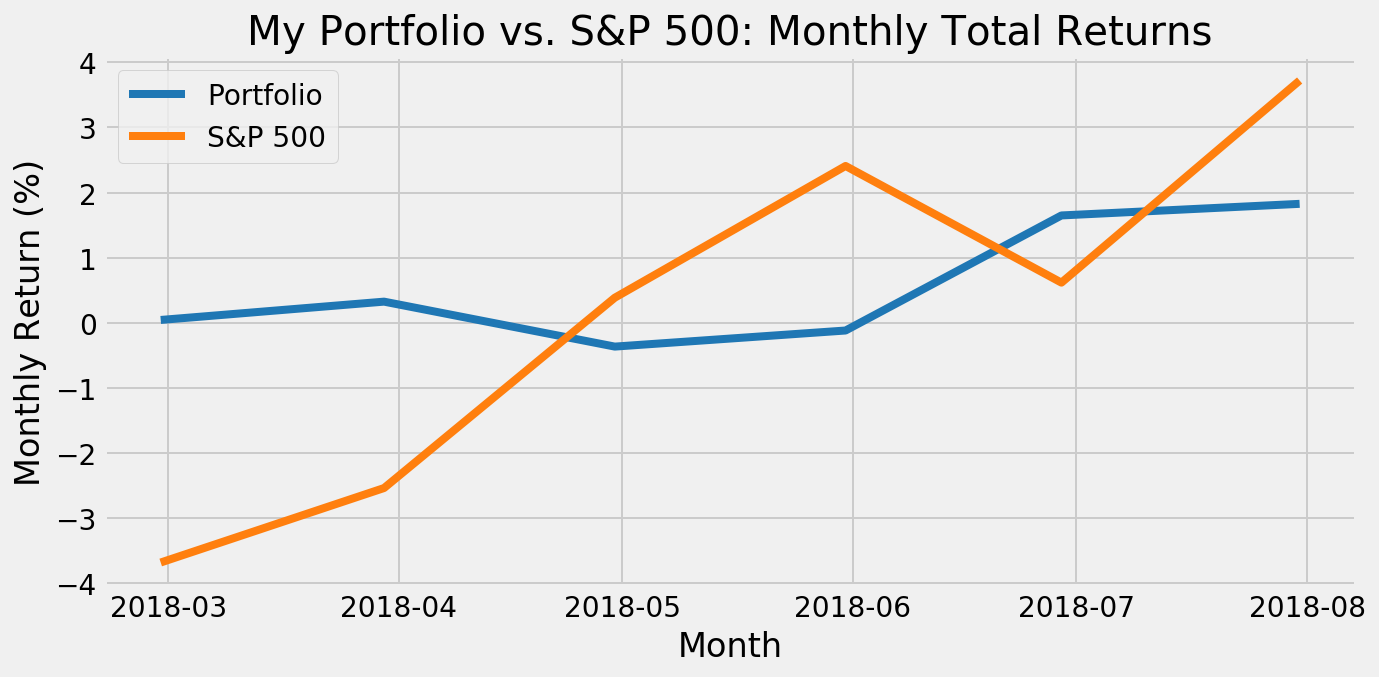

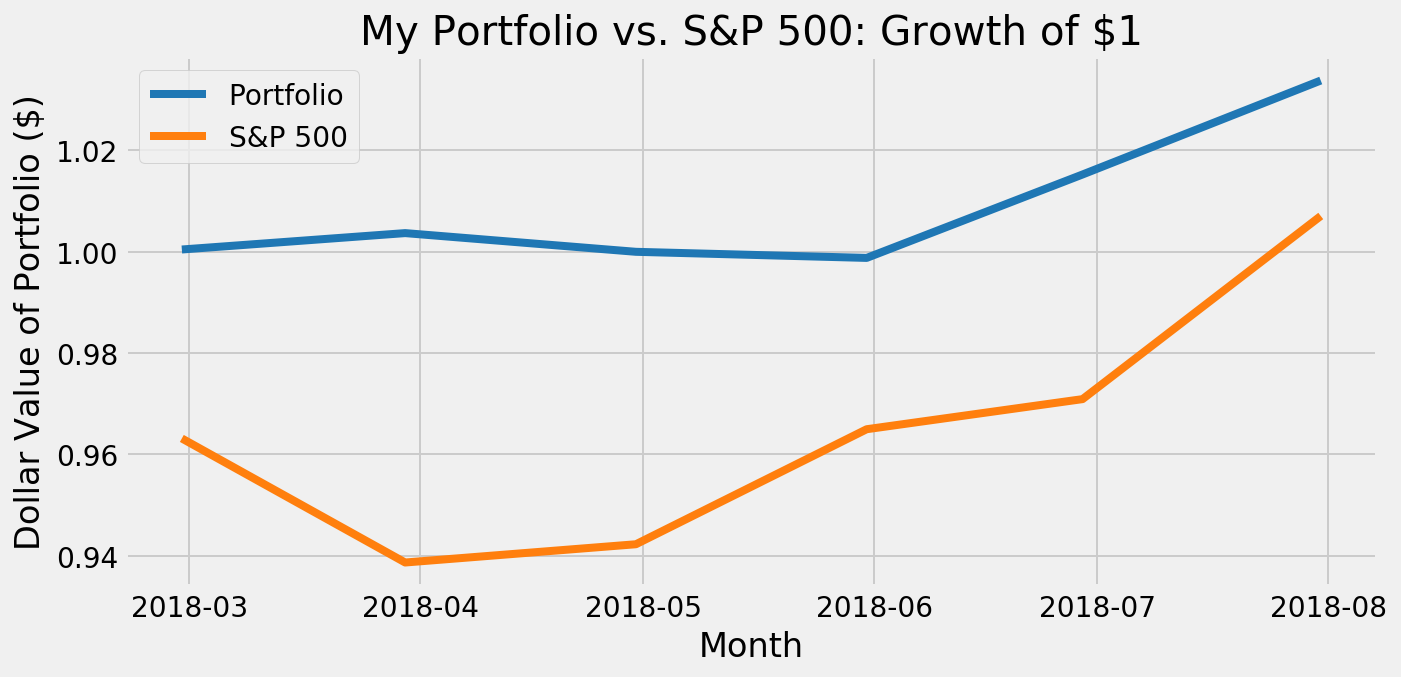

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))

#for name, group in by_label:
plt.subplot(211)
plt.plot(return_df['Date'][start_index+1:end_index+1], 
         return_df['Portfolio Total Return (%)'][start_index+1:end_index+1], label='Portfolio',color='tab:blue')
plt.plot(return_df['Date'][start_index+1:end_index+1], 
         return_df['S&P 500 Total Return (%)'][start_index+1:end_index+1], label='S&P 500',color='tab:orange')

plt.ylabel('Monthly Return (%)')
plt.xlabel('Month')
plt.title('My Portfolio vs. S&P 500: Monthly Total Returns')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))

#for name, group in by_label:
plt.subplot(212)
plt.plot(return_df['Date'][start_index+1:end_index+1], 
         return_df['Portfolio Growth of $1'][start_index+1:end_index+1], label='Portfolio',color='tab:blue')
plt.plot(return_df['Date'][start_index+1:end_index+1], 
         return_df['S&P 500 Growth of $1'][start_index+1:end_index+1], label='S&P 500',color='tab:orange')

plt.ylabel('Dollar Value of Portfolio ($)')
plt.xlabel('Month')
plt.title('My Portfolio vs. S&P 500: Growth of $1')
plt.legend()

#plt.tight_layout()
plt.show()